## Image Segmentation - Chest X Ray Dataset

To know the shape of the object, which pixel belongs to which object, etc, In this case, you need to assign a class to each pixel of the image — this task is known as segmentation. A segmentation model returns much more detailed information about the image.

## Creating Unet Model from scratch

The UNET Model used has a series of:


*   **Convolution Block**: It is a sequence of convolutional layers with batch normalization and activation layers. The purpose of the convolution block is to extract features from the input data.

*   **Encoder Block**: It consists of a series of convolution blocks and pooling layers. The purpose of the encoder block is to reduce the spatial resolution of the input data and increase the number of feature maps, while maintaining the important features

*   **Decoder Block**: It consists of a series of convolution blocks and upsampling layers. The purpose of the decoder block is to increase the spatial resolution of the feature maps and combine them with the features from the corresponding encoder block, in order to reconstruct the original input data




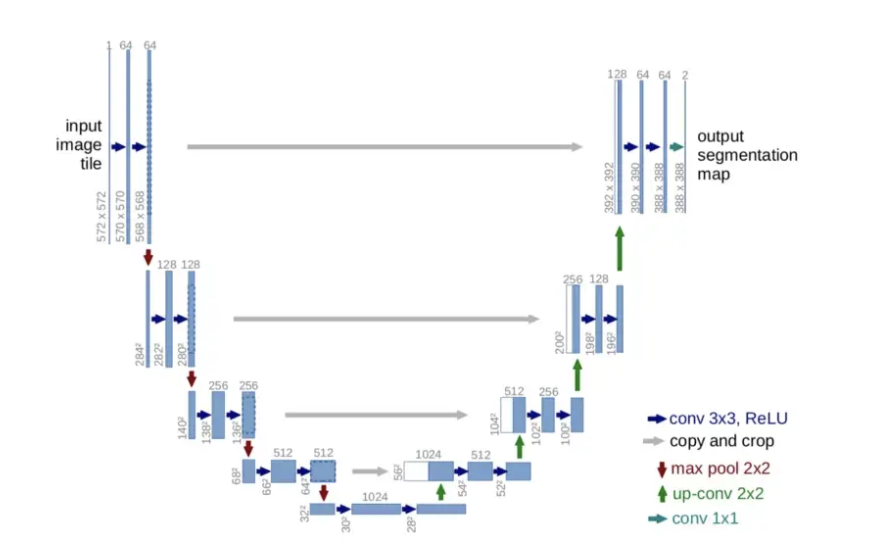

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

Number of channels is 1, since it is a binary segmentation with one foreground class that is lung area. Sigmoid gives output as 0 or 1  


*   1- foreground class (Lung area)

*   0 - background class (black area)




In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
# from model import build_unet
# from metrics import dice_loss, dice_coef, iou

## Defining Evaluation Metrics

Dice Coefficient or Dice similarity coefficient (DSC) is a statistical tool which measures the similarity between two sets of data.

It is given by:

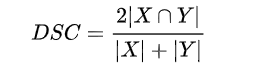

In Image Segmentation,

*   X is the predicted set of pixels
*   Y is the ground truth


**Dice Score = 1 - Dice Loss(DSC)**


IOU is Intersection Over Union, different that dice loss.

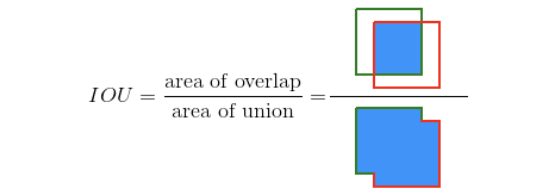


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
H = 512
W = 512

In [ ]:
import os
def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/CV upskilling/Datasets/MontgomerySet/' 
# path1 = '/content/drive/MyDrive/Colab Notebooks/CV upskilling/Datasets/MontgomerySet/ManualMask/leftMask' 
# path2 = '/content/drive/MyDrive/Colab Notebooks/CV upskilling/Datasets/MontgomerySet/ManualMask/rightMask' 


## Loading data and splitting

Loading the data and spliting it into train, test and validation with a random state of 42 and split=0.1 (80-10-10)

In [ ]:
def load_data(dataset_path, split=0.1):
    images = sorted(glob(os.path.join(dataset_path, "CXR_png", "*.png")))
    masks1 = sorted(glob(os.path.join(dataset_path, "ManualMask", "leftMask", "*.png")))
    masks2 = sorted(glob(os.path.join(dataset_path, "ManualMask", "rightMask", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y1, valid_y1 = train_test_split(masks1, test_size=split_size, random_state=42)
    train_y2, valid_y2 = train_test_split(masks2, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y1, test_y1 = train_test_split(train_y1, test_size=split_size, random_state=42)
    train_y2, test_y2 = train_test_split(train_y2, test_size=split_size, random_state=42)

    return (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2)

In [ ]:
(train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2) = load_data(dataset_path)

## Reading Images



*   Reading every images in the dataset.

*   Normalize the value to 0 to 1 by dividing with 255.






In [ ]:
def read_image(dataset_path):
    x = cv2.imread(dataset_path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [ ]:
x = read_image(train_x[0])
print(x.shape)
# cv2.imwrite("img.png", x*255)

(512, 512, 3)


## Reading Masks



*   Reading every masks in the dataset, both left and right and adding both the masks. 
*   The threshhold of 0.5 is used such that the value of mask becomes either 0 or 1.



In [ ]:
def read_mask(path1, path2):
    x1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    x2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
    x = x1 + x2
    x = cv2.resize(x, (W, H))
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
x = read_mask(train_y1[0], train_y2[0])
print(x.shape)
# cv2.imwrite("mask.png", x*255)

(512, 512, 1)


In [ ]:
# This function takes path for image and mask and gives tensor. To include the function which are not on tensorflow use numpy_function.

def tf_parse(x, y1, y2):
    def _parse(x, y1, y2):
        x = x.decode()
        y1 = y1.decode()
        y2 = y2.decode()

        x = read_image(x) # gives array
        y = read_mask(y1, y2)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y1, y2], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [ ]:
def tf_dataset(X, Y1, Y2, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y1, Y2))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
print(f"Train: {len(train_x)} - {len(train_y1)} - {len(train_y2)}")
print(f"Valid: {len(valid_x)} - {len(valid_y1)} - {len(valid_y2)}")
print(f"Test: {len(test_x)} - {len(test_y1)} - {len(test_y2)}")

Train: 112 - 112 - 112
Valid: 13 - 13 - 13
Test: 13 - 13 - 13


In [ ]:
batch_size = 2
lr = 1e-5
num_epochs = 100

In [ ]:
train_dataset = tf_dataset(train_x, train_y1, train_y2, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y1, valid_y2, batch=batch_size)

## Displaying the data

The data has the input Image and the true mask which is displayed using the function.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

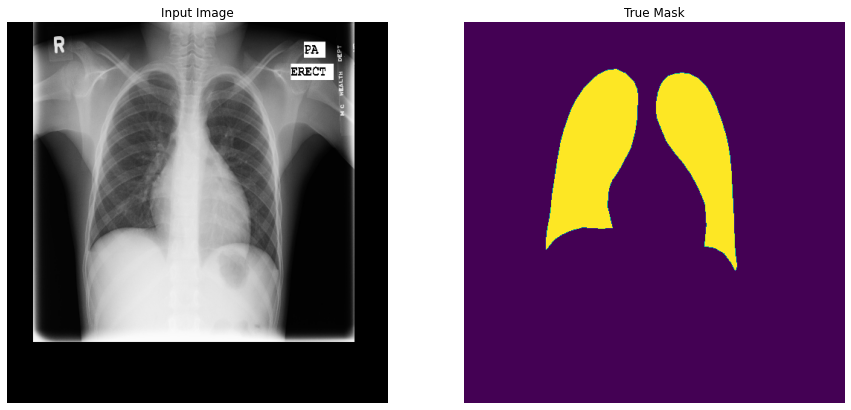

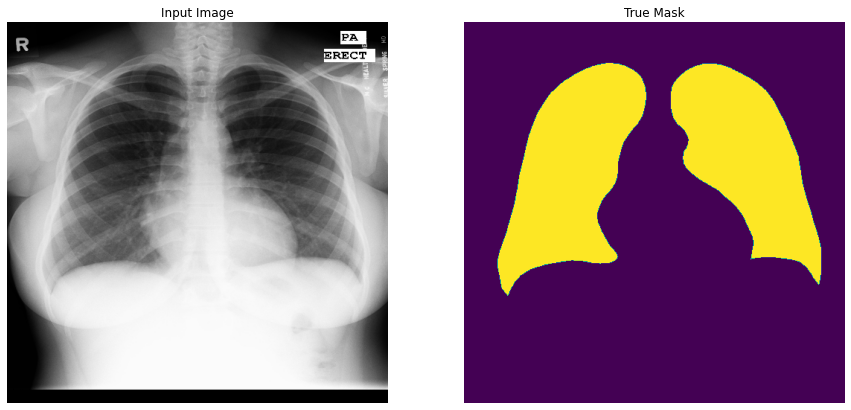

In [ ]:
import matplotlib.pyplot as plt
for images, masks in train_dataset.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Model Building

Building the unet model


*   Optimizer: adam


*   Loss: binary cross entropy

*   Evaluation metrics: iou, dice_coeff, recall, precision 



In [ ]:
# OUTPUT_CLASSES = 3

model = build_unet((H, W, 3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
model_path = os.path.join("files", "model.h5")
# csv_path = os.path.join("files", "data.csv")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)
        
    ]

In [ ]:
model_history = model.fit(train_dataset, epochs=num_epochs,
                          validation_data=valid_dataset,
                          callbacks=callbacks)

Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 0.5258 - dice_coef: 0.4742 - iou: 0.3166 - recall: 0.7346 - precision: 0.5237
Epoch 1: val_loss improved from inf to 0.65069, saving model to files/model.h5
56/56 [==============================] - 272s 4s/step - loss: 0.5258 - dice_coef: 0.4742 - iou: 0.3166 - recall: 0.7346 - precision: 0.5237 - val_loss: 0.6507 - val_dice_coef: 0.3524 - val_iou: 0.2150 - val_recall: 0.9754 - val_precision: 0.3173 - lr: 1.0000e-05
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.3436 - dice_coef: 0.6564 - iou: 0.4952 - recall: 0.9026 - precision: 0.6646
Epoch 2: val_loss improved from 0.65069 to 0.64137, saving model to files/model.h5
56/56 [==============================] - 49s 876ms/step - loss: 0.3436 - dice_coef: 0.6564 - iou: 0.4952 - recall: 0.9026 - precision: 0.6646 - val_loss: 0.6414 - val_dice_coef: 0.3565 - val_iou: 0.2181 - val_recall: 0.9730 - val_precision: 0.3159 - lr: 1.0000e-05
Epoch 3/100
56/5

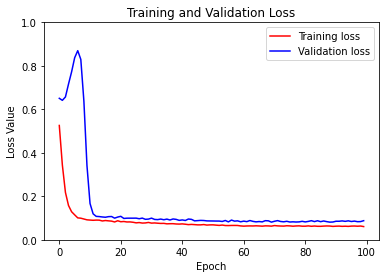

In [ ]:
import matplotlib.pyplot as plt
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Evaluation on test dataset

In [ ]:
create_dir("result")
# result_path = '/content/drive/MyDrive/Colab Notebooks/CV upskilling/results/'

In [ ]:
from tqdm import tqdm
for x, y1, y2 in tqdm(zip(test_x, test_y1, test_y2), total=len(test_x)):
  image_name = x.split("/")[-1]
  # print(image_name)
  # break

  # Reading the image
  ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
  ori_x = cv2.resize(ori_x, (W, H))
  x = ori_x/255.0
  x = x.astype(np.float32)
  x = np.expand_dims(x, axis=0)

  # Reading the mask 
  ori_y1 = cv2.imread(y1, cv2.IMREAD_GRAYSCALE)
  ori_y2 = cv2.imread(y2, cv2.IMREAD_GRAYSCALE)
  ori_y = ori_y1 + ori_y2
  ori_y = cv2.resize(ori_y, (W, H))
  ori_y = np.expand_dims(ori_y, axis=-1)  ## (512, 512, 1)
  ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)  ## (512, 512, 3) number of channels increased from 1 to 3

  # Predicting the mask
  y_pred = model.predict(x)[0] > 0.5
  y_pred = y_pred.astype(np.int32)

  #  Saving the predicted mask along with the image and ground
  save_image_path = f"result/{image_name}"
  y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

  sep_line = np.ones((H, 10, 3)) * 255

  cat_image = np.concatenate([ori_x, sep_line, ori_y, sep_line, y_pred*255], axis=1)
  cv2.imwrite(save_image_path, cat_image)

  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 1s 586ms/step


  8%|▊         | 1/13 [00:02<00:35,  3.00s/it]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 2/13 [00:06<00:36,  3.31s/it]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 3/13 [00:09<00:29,  2.96s/it]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 4/13 [00:11<00:24,  2.77s/it]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 5/13 [00:13<00:20,  2.60s/it]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 6/13 [00:16<00:17,  2.53s/it]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 7/13 [00:18<00:15,  2.53s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 8/13 [00:21<00:12,  2.51s/it]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 9/13 [00:24<00:10,  2.70s/it]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 10/13 [00:27<00:08,  2.68s/it]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 11/13 [00:29<00:05,  2.59s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 12/13 [00:31<00:02,  2.53s/it]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 13/13 [00:34<00:00,  2.63s/it]


## Results

In [ ]:
# Utility function for visualizing images and masks
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
pred_mask = model.predict(x)[0] > 0.5
pred_mask = pred_mask.astype(np.int32)

1/1 [==============================] - 0s 21ms/step


In [ ]:
pred_mask = np.concatenate([pred_mask, pred_mask, pred_mask], axis=-1)

  0%|          | 0/13 [00:00<?, ?it/s]

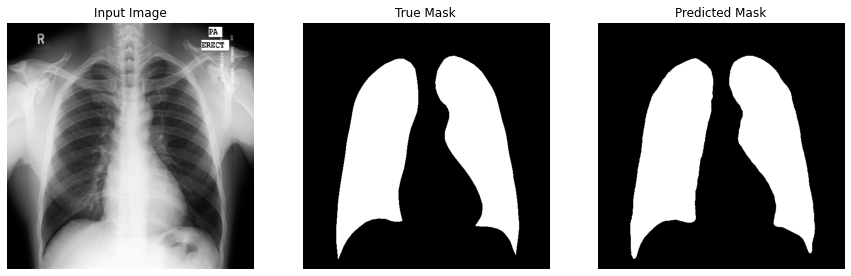

  8%|▊         | 1/13 [00:00<00:05,  2.25it/s]

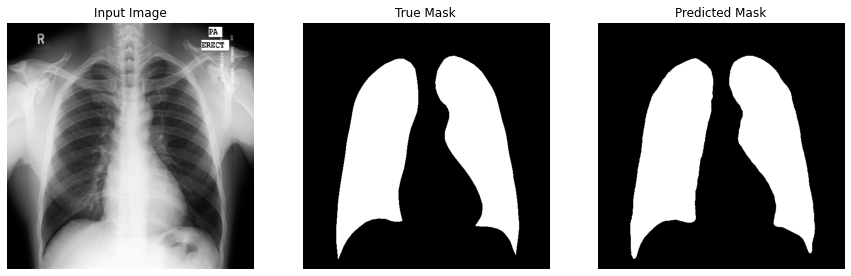

 15%|█▌        | 2/13 [00:00<00:05,  2.14it/s]

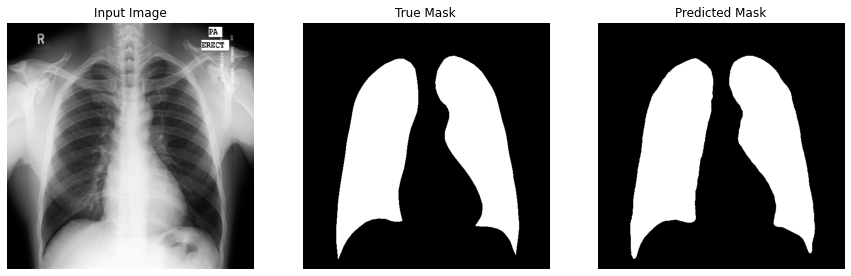

 23%|██▎       | 3/13 [00:01<00:04,  2.24it/s]

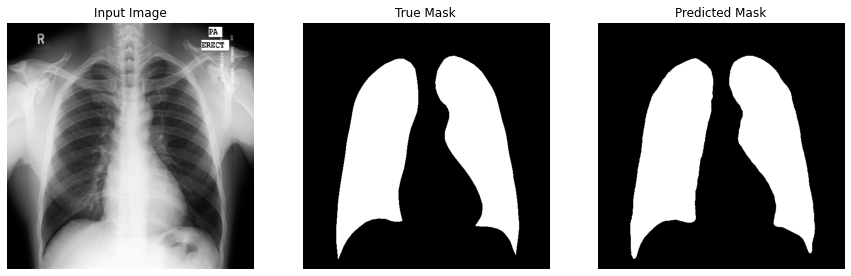

 31%|███       | 4/13 [00:01<00:03,  2.69it/s]

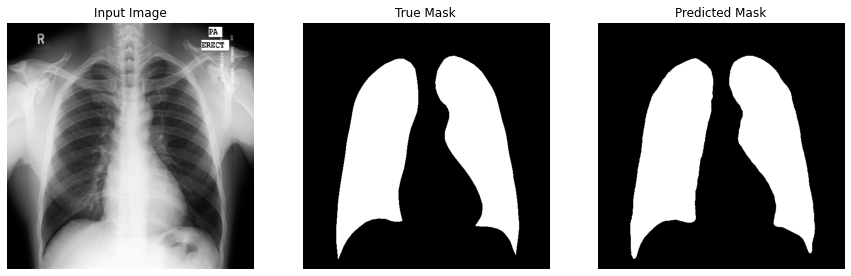

 38%|███▊      | 5/13 [00:01<00:02,  3.06it/s]

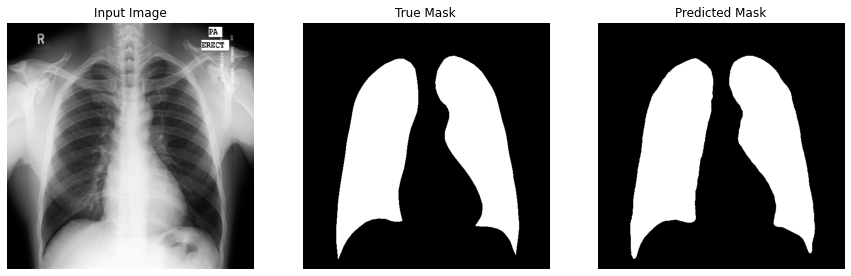

 46%|████▌     | 6/13 [00:02<00:02,  3.34it/s]

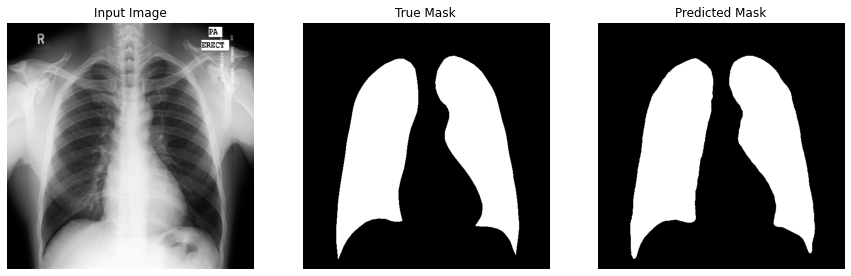

 54%|█████▍    | 7/13 [00:02<00:01,  3.51it/s]

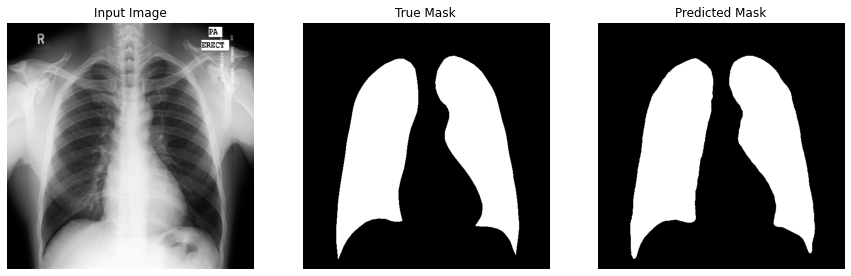

 62%|██████▏   | 8/13 [00:02<00:01,  3.65it/s]

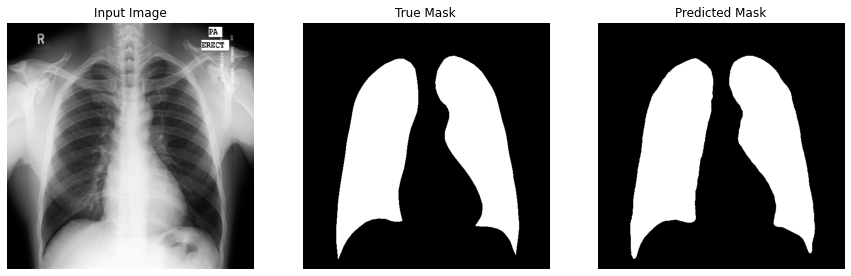

 69%|██████▉   | 9/13 [00:03<00:01,  3.00it/s]

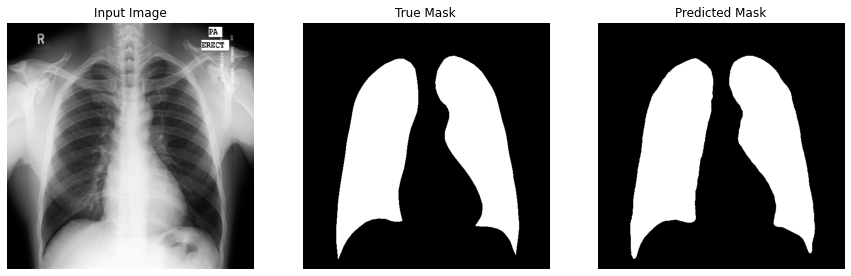

 77%|███████▋  | 10/13 [00:03<00:00,  3.22it/s]

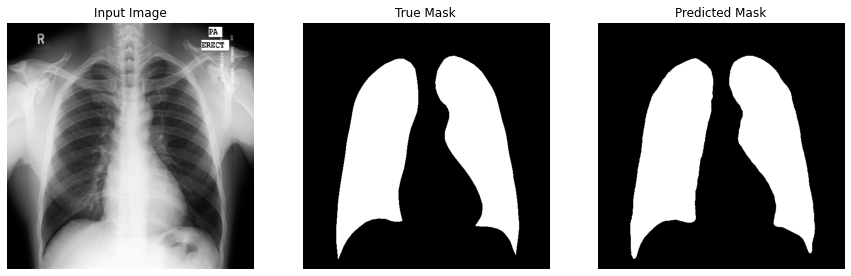

 85%|████████▍ | 11/13 [00:03<00:00,  3.41it/s]

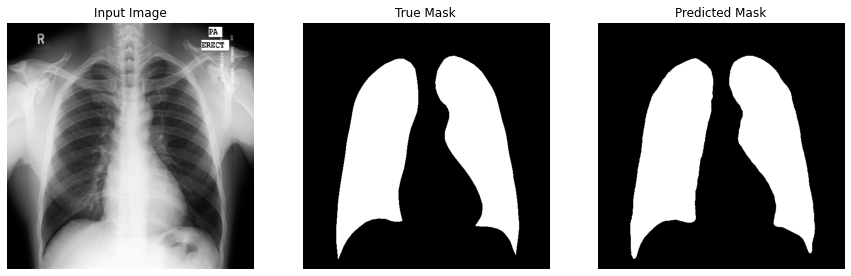

 92%|█████████▏| 12/13 [00:03<00:00,  3.49it/s]

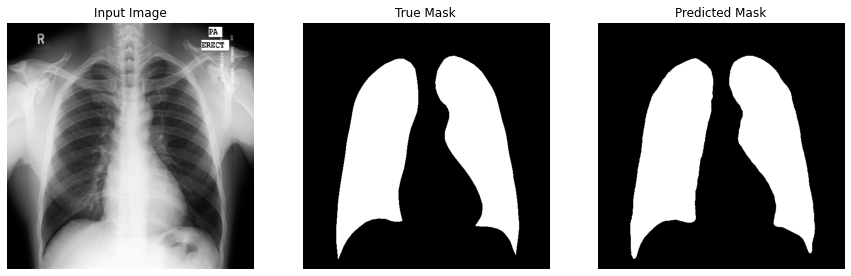

100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


In [ ]:
for x, y1, y2 in tqdm(zip(test_x, test_y1, test_y2), total=len(test_x)):
  display([ori_x, ori_y, pred_mask])